# Code

In [1]:
%pip install highway-env==1.8.2 matplotlib==3.8.3 moviepy==1.0.3 numpy==1.26.4 pyvirtualdisplay==3.0 statsmodels==0.14.1 tensorflow==2.15.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import random
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LSTM

class NeuralNet():
    def __init__(self, input_dim, output_dim, learning_rate):
        # 2d conv net. Used for stack size = 1
        # Len 3 because the input_dim is (1, width, height)
        if len(input_dim) == 3:
            self.model = keras.Sequential([
                Conv2D(32, (3, 3), activation='relu', input_shape=input_dim, data_format='channels_first', padding='same'),
                MaxPooling2D((2, 2), strides=(2, 2)),
                Conv2D(64, (3, 3), activation='relu', data_format='channels_first', padding='same'),
                MaxPooling2D((2, 2), strides=(2, 2)),
                Flatten(),
                Dropout(0.5),
                Dense(128, activation='relu'),
                Dense(output_dim, activation=None)
            ])

        # Time distributed 2d conv net. Use this for stack size > 1
        # Input shape becomes (stack_size, width, height, channels)
        # We need to add a channel dimension to the input shape, even if it's grayscale (because Conv2D expects a channel dimension).
        # TimeDistributed applies the conv layers to each image, instead of the whole stack. The weights are the same for each image.
        # Extra LSTM layer to process the time dimension
        # Will need a lot more training data to get good results
        else: # len(input_dim) == 4 if stack size > 1, where input_dim is (stack_size, width, height, 1)
            self.model = keras.Sequential([
                TimeDistributed(Conv2D(32, (3, 3), activation='relu', padding='same'), input_shape=input_dim),
                TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
                TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same')),
                TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))),
                TimeDistributed(Flatten()),
                LSTM(128, activation='relu', return_sequences=False),
                Dropout(0.5),
                Dense(128, activation='relu'),
                Dense(output_dim, activation=None)
            ])

        self.model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    def save_model(self, dir):
        self.model.save(dir)


    def load_model(self, dir):
        self.model = load_model(dir)


class Memory():
    def __init__(self, max_experiences, input_dim) -> None:
        self.states = np.zeros((max_experiences, *input_dim))
        self.actions = np.zeros(max_experiences, dtype=np.int32)
        self.new_states = np.zeros((max_experiences, *input_dim), dtype=np.float32)
        self.rewards = np.zeros(max_experiences, dtype=np.float32)
        self.dones = np.zeros(max_experiences, dtype=np.int32)
        self.exp_counter = 0 # num experiences. Always incrementing and never reset
        self.index = 0 # index of the last experience added. Looping from 0 to max_experiences
        self.max_experiences = max_experiences # max experiences in memory


    def add_experience(self, state, action, new_state, reward, done):
        self.index = self.exp_counter % self.max_experiences

        self.states[self.index] = state
        self.actions[self.index] = action
        self.new_states[self.index] = new_state
        self.rewards[self.index] = reward
        self.dones[self.index] = done

        self.exp_counter += 1
        self.index += 1

    def get_experience_batch(self, batch_size):
        indices = np.random.choice(min(self.exp_counter, self.max_experiences), batch_size, replace=False)

        out_states = self.states[indices]
        out_actions = self.actions[indices]
        out_new_states = self.new_states[indices]
        out_rewards = self.rewards[indices]
        out_dones = self.dones[indices]

        return out_states, out_actions, out_new_states, out_rewards, out_dones


class Agent():
    def __init__(self, max_experiences, input_dim, num_actions, learning_rate, batch_size, exploration_rate_start, gamma, exploration_rate_decrement, exploration_rate_min, update_target_iters) -> None:
        self.memory = Memory(max_experiences, input_dim)
        self.batch_size = batch_size
        self.exploration_rate = exploration_rate_start
        self.num_actions = num_actions
        self.gamma = gamma
        self.exploration_rate_decrement = exploration_rate_decrement
        self.exploration_rate_min = exploration_rate_min
        self.update_target_iters = update_target_iters

        # estimate best action
        self.neural_net = NeuralNet(input_dim, num_actions, learning_rate)
        # target - estimate q val of selected action
        self.target_neural_net = NeuralNet(input_dim, num_actions, learning_rate)

        # copy weights from neural_net to target_neural_net
        self.target_neural_net.model.set_weights(self.neural_net.model.get_weights())

    # 1º - choose action (choose_action)
    # 2º - add experience to memory (memory.add)
    # 3º - choose batch, learn (learn)

    def decrement_exploration_rate(self):
        self.exploration_rate = max(self.exploration_rate - self.exploration_rate_decrement, self.exploration_rate_min)

    def choose_action(self, state):
        output = None

        if self.exploration_rate > random.random():   # explore
            output = random.randrange(self.num_actions)
        else:                                         # choose best action
            output = np.argmax(self.neural_net.model.predict(np.array([state]), verbose=None))

        return output

    def learn(self,):
        # can't fill the batch yet, do nothing
        if self.memory.exp_counter < self.batch_size:
            return

        batch_states, batch_actions, batch_new_states, batch_rewards, batch_dones = self.memory.get_experience_batch(self.batch_size)

        print(batch_states.shape)
        print(batch_new_states.shape)

        # target network q-values on new state
        target_new_state_qs = self.target_neural_net.model.predict_on_batch(batch_new_states)

        # online network q-value of new state
        new_state_qs = self.neural_net.model.predict_on_batch(batch_new_states)

        # get best action on new state using online model
        # argmax returns the index of the max value in the array
        argmax_action = np.argmax(new_state_qs, axis=1)

        # q-values of current state. Will be used as the target y after updating the q-values
        target_qs = self.neural_net.model.predict_on_batch(batch_states)
        # need to create this array to access the correct batch in the next line
        batch_index = np.arange(self.batch_size)
        # update q-values of actions taken
        target_qs[batch_index, batch_actions] = batch_rewards + (1-batch_dones) * self.gamma * target_new_state_qs[batch_index, argmax_action]

        # target_qs will be the target. The method runs forward pass and calculates back prop, therefore we provide batch_states as input
        self.neural_net.model.fit(batch_states, target_qs, verbose=0)

        self.decrement_exploration_rate()

        # update target network every update_target_iters iterations
        if self.memory.exp_counter % self.update_target_iters == 0:
            self.target_neural_net.model.set_weights(self.neural_net.model.get_weights())

2024-02-17 00:21:10.125295: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-17 00:21:10.179815: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-17 00:21:10.179867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-17 00:21:10.181065: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-17 00:21:10.190915: I tensorflow/core/platform/cpu_feature_guar

# Setup environment


In [3]:
width = 128
height = 64
stack_size = 1

In [4]:
import gymnasium as gym
from gymnasium.wrappers import TransformObservation

# choose between highway-fast-v0, merge-v0, roundabout-v0, intersection-v0
env = gym.make('highway-fast-v0', render_mode="rgb_array")

env.unwrapped.configure({
    "normalize_reward": True,

    "observation": {
        "type": "GrayscaleObservation",
        "observation_shape": (width, height),
        "stack_size": stack_size,
        "weights": [0.2989, 0.5870, 0.1140],  # weights for RGB conversion
        "scaling": 1.75,
    },
})

# add channel dimension to input shape if stack_size > 1
input_dim = (stack_size, width, height, 1) if stack_size > 1 else (stack_size, width, height)
if stack_size > 1:
    env = TransformObservation(env, lambda obs: np.expand_dims(obs, axis=-1))

# Train model

In [5]:
episodes = 500

agent = Agent(
    max_experiences=15000,
    input_dim=input_dim,
    num_actions=env.action_space.n,
    learning_rate=5e-4,
    batch_size=32,
    exploration_rate_start=1.0,
    gamma=0.99,
    exploration_rate_decrement=0.005,
    exploration_rate_min=0.001,
    update_target_iters=50,
)

scores = []

for i in range(episodes):
    obs, info = env.reset()
    current_score = 0

    done = truncated = False
    while not (done or truncated):
        action = agent.choose_action(obs)

        new_obs, reward, done, truncated, info = env.step(action)

        agent.memory.add_experience(obs, action, new_obs, reward, done)
        agent.learn()
        # env.render()
        obs = new_obs

        current_score += reward

    scores.append(current_score)

    print("Episode: {}/{} Score: {}".format(i + 1, episodes, current_score))

print("Average score: {}".format(np.average(scores)))
env.close()

2024-02-17 00:21:13.128867: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Episode: 1/500 Score: 13.064633584828226
Episode: 2/500 Score: 9.911747945112754
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
Episode: 3/500 Score: 13.268123584830258
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1)
(32, 4, 128, 64, 1

KeyboardInterrupt: 

# Training graphs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def graph(x,y):
  # Calculate Lowess smoothed line
  lowess = sm.nonparametric.lowess(y, x, frac=0.3)

  # Calculate residuals and estimate uncertainty bounds
  residuals = y - lowess[:, 1]
  std_dev = np.std(residuals)
  lower_bound = lowess[:, 1] - 2 * std_dev
  upper_bound = lowess[:, 1] + 2 * std_dev

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.plot(lowess[:, 0], lowess[:, 1], label='Lowess smoothed line', color='blue')
  plt.fill_between(lowess[:, 0], lower_bound, upper_bound, color='blue', alpha=0.3, label='Uncertainty bounds')
  plt.scatter(x, y, alpha=0.5, label='Data points', color='grey')
  plt.xlabel('Episodes')
  plt.ylabel('Scores')
  plt.title('Scores over episodes')
  plt.legend()
  plt.show()


Load list of scores, display them in graph

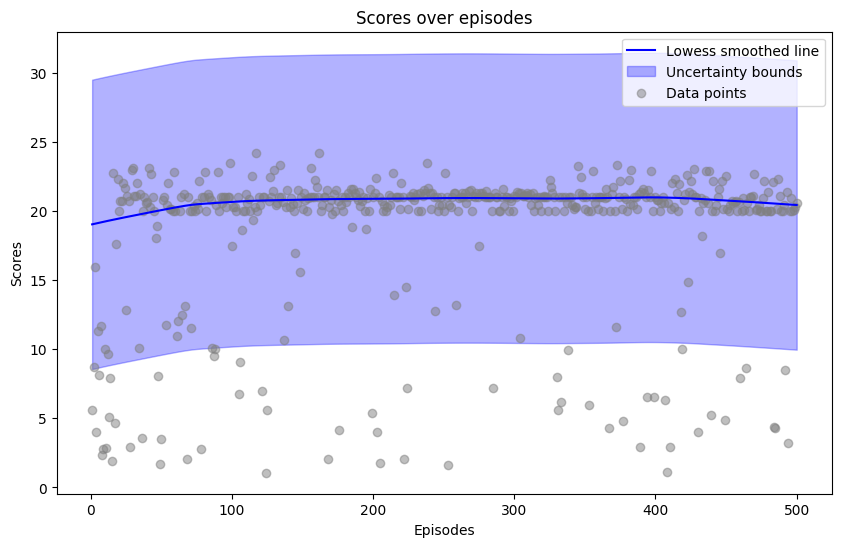

In [ ]:
x = np.arange(start=1, stop=episodes+1)
y = np.array(scores)

graph(np.arange(start=1, stop=episodes+1), np.array(scores))

# Save model

In [ ]:
agent.neural_net.save_model("model-ddqn")
agent.target_neural_net.save_model("model-ddqn-target")

INFO:tensorflow:Assets written to: model-ddqn/assets


INFO:tensorflow:Assets written to: model-ddqn/assets


INFO:tensorflow:Assets written to: model-ddqn-target/assets


INFO:tensorflow:Assets written to: model-ddqn-target/assets


# Test existing model


In [ ]:
# Visualization utils. https://github.com/Farama-Foundation/HighwayEnv/blob/master/scripts/utils.py
import base64
from pathlib import Path
from gymnasium.wrappers import RecordVideo
from IPython import display as ipythondisplay

def record_videos(env, video_folder="videos"):
    wrapped = RecordVideo(
        env, video_folder=video_folder, episode_trigger=lambda e: True
    )

    # Capture intermediate frames
    env.unwrapped.set_record_video_wrapper(wrapped)

    return wrapped


In [ ]:
import datetime

now = datetime.datetime.now()
now_str = now.strftime("%Y%m%d_%H%M%S")
video_folder = f"videos_{now_str}"

_env = record_videos(env, video_folder=video_folder)

episodes = 5

agent = Agent(
    max_experiences=15000,
    input_dim=input_dim,
    num_actions=env.action_space.n,
    learning_rate=5e-4,
    batch_size=32,
    exploration_rate_start=0.0,
    gamma=0.99,
    exploration_rate_decrement=0,
    exploration_rate_min=0,
    update_target_iters=50,
)

# load model file
agent.neural_net.load_model("model-ddqn")
agent.target_neural_net.load_model("model-ddqn-target")

scores = []
crashes = []
speeds = []

for i in range(episodes):
    obs, info = _env.reset()

    current_score = 0
    current_ep_speeds = []
    hasCrashed = False

    done = truncated = False
    while not (done or truncated):
        action = agent.choose_action(obs)
        new_obs, reward, done, truncated, info = _env.step(action)

        if _env.unwrapped.vehicle.crashed:
            hasCrashed = True

        current_ep_speeds.append(_env.unwrapped.vehicle.speed)

        _env.render()
        obs = new_obs

        current_score += reward


    average_speed = np.average(np.array(current_ep_speeds))

    scores.append(current_score)
    crashes.append(hasCrashed)
    speeds.append(average_speed)

    print(
        "Episode: {}/{} Score: {} Crashed: {} Average speed: {}".format(
            i + 1, episodes, current_score, hasCrashed, average_speed
        )
    )

print("Average score: {}".format(np.average(scores)))

_env.close()

# show all videos
video_path = Path(video_folder)
video_files = list(video_path.glob("*.mp4"))
video_files.sort()
for video_file in video_files:
    print(video_file)
    video = open(video_file, "rb").read()
    video_url = f"data:video/mp4;base64,{base64.b64encode(video).decode()}"
    ipythondisplay.display(
        ipythondisplay.HTML(
            f"""<video alt="test" autoplay loop controls style="height: 400px;">
        <source src="{video_url}" type="video/mp4" />
    </video>"""
        )
    )

Moviepy - Building video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-0.mp4.
Moviepy - Writing video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-0.mp4
Episode: 1/5 Score: 20.02022116903634 Crashed: False Average speed: 20.025276461295423
Moviepy - Building video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-1.mp4.
Moviepy - Writing video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-1.mp4
Episode: 2/5 Score: 20.120177620259774 Crashed: False Average speed: 20.025276461295423
Moviepy - Building video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-2.mp4.
Moviepy - Writing video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-2.mp4



Moviepy - Done !
Moviepy - video ready /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-2.mp4
Episode: 3/5 Score: 20.286265111013634 Crashed: False Average speed: 20.358609794628755
Moviepy - Building video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-3.mp4.
Moviepy - Writing video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-3.mp4



Moviepy - Done !
Moviepy - video ready /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-3.mp4
Episode: 4/5 Score: 21.020221169036326 Crashed: False Average speed: 20.025276461295423
Moviepy - Building video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-4.mp4.
Moviepy - Writing video /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-4.mp4



Moviepy - Done !
Moviepy - video ready /home/rpedro/dqn/videos_20240217_001834/rl-video-episode-4.mp4
Episode: 5/5 Score: 20.153554502369673 Crashed: False Average speed: 20.191943127962084
Average score: 20.32008791434315
videos_20240217_001834/rl-video-episode-0.mp4


videos_20240217_001834/rl-video-episode-1.mp4


videos_20240217_001834/rl-video-episode-2.mp4


videos_20240217_001834/rl-video-episode-3.mp4


videos_20240217_001834/rl-video-episode-4.mp4
